In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122],
 [Text(0, 0, 'A0A0R4I961'),
  Text(1, 0, 'B5XAZ0'),
  Text(2, 0, 'D2AJU0'),
  Text(3, 0, 'O00571'),
  Text(4, 0, 'O08722'),
  Text(5, 0, 'O08967'),
  Text(6, 0, 'O60741'),
  Text(7, 0, 'O76074'),
  Text(8, 0, 'O95267'),
  Text(9, 0, 'O95376'),
  Te

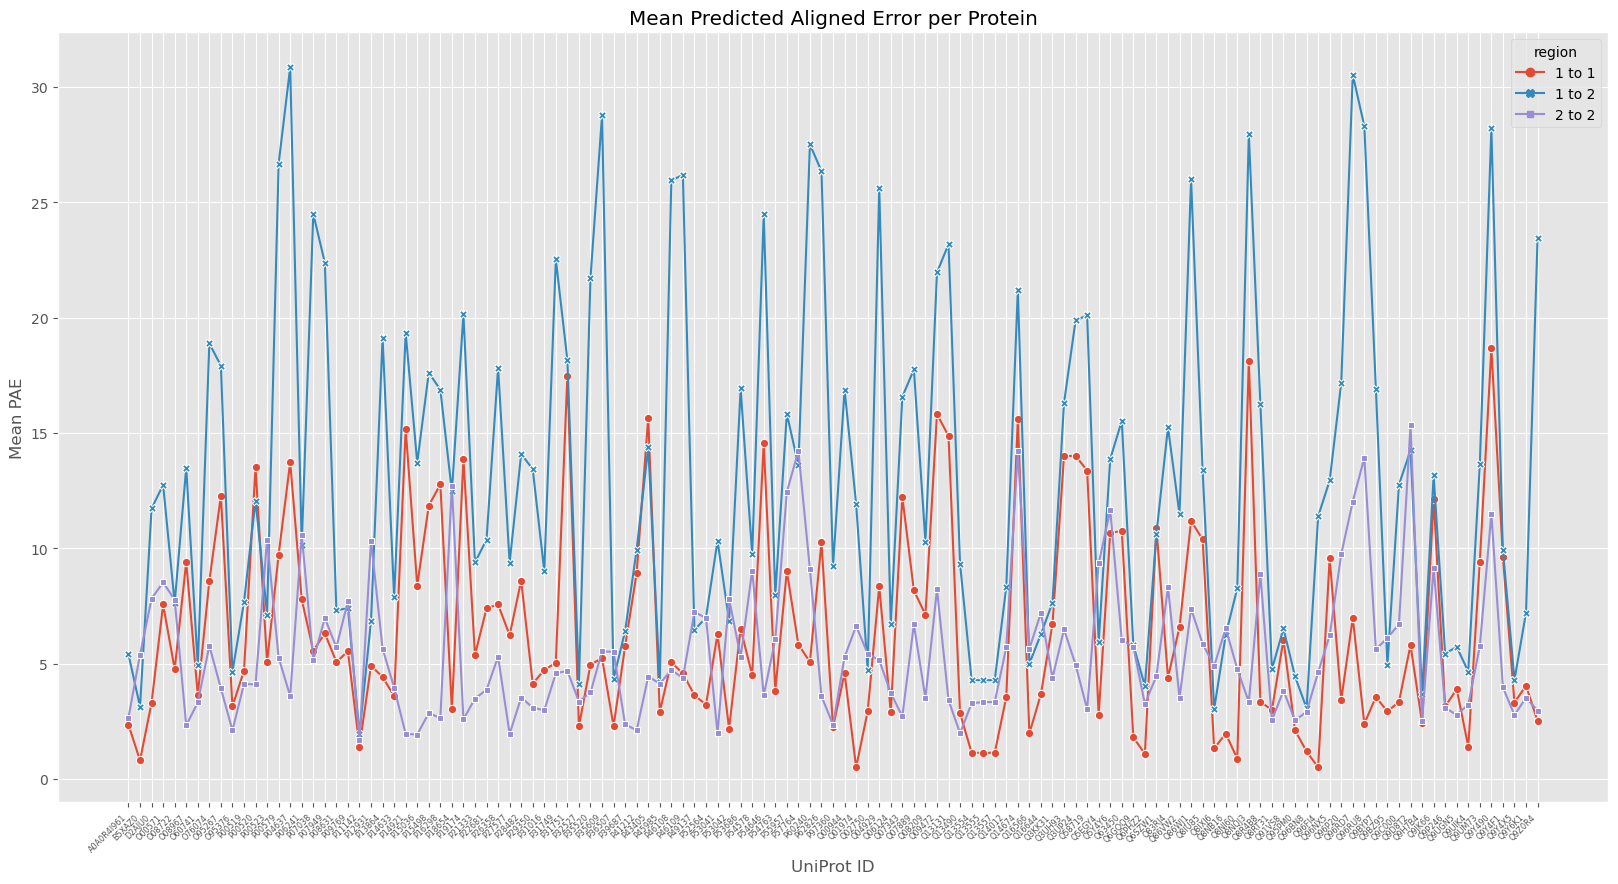

In [3]:
# This is for calculating percent that are within 2.5A of closed position. 
df_disorder = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_pae = df_disorder[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

plt.style.use('ggplot')
# Rename columns
df_pae = df_pae.rename(columns={'mean_pae_1_1': '1 to 1', 'mean_pae_1_2': '1 to 2', 'mean_pae_2_2': '2 to 2'})
df_pae = df_pae.drop_duplicates()
df_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 10))

sns.lineplot(data=df_melt, x='uniprot', y='mean_pae', hue='region', style='region', markers=True, dashes=False, ax=ax)
ax.set_xlabel('UniProt ID')
ax.set_ylabel('Mean PAE')
ax.set_title('Mean Predicted Aligned Error per Protein')
plt.xticks(rotation=45, fontsize='xx-small', ha='right')

# plt.savefig('./project_pipeline/data/figures/mean_pae.png', dpi=300, bbox_inches='tight')

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

Number  of Active and open: 141
Number of active and closed: 63
Number of autoinhibited and open: 7
Number of autoinhibited and closed: 339


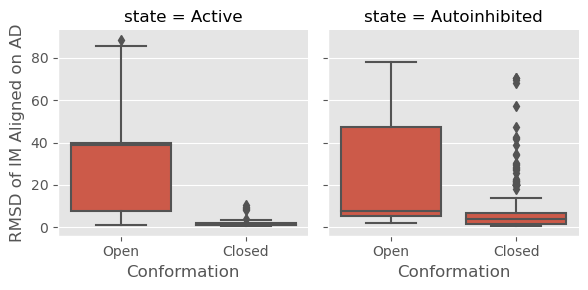

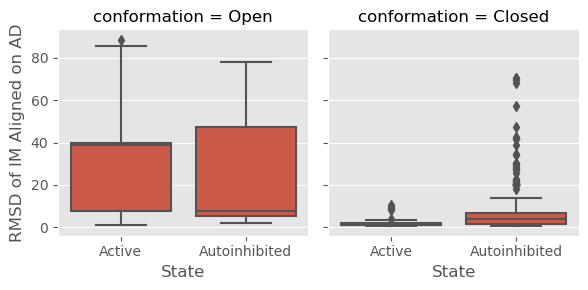

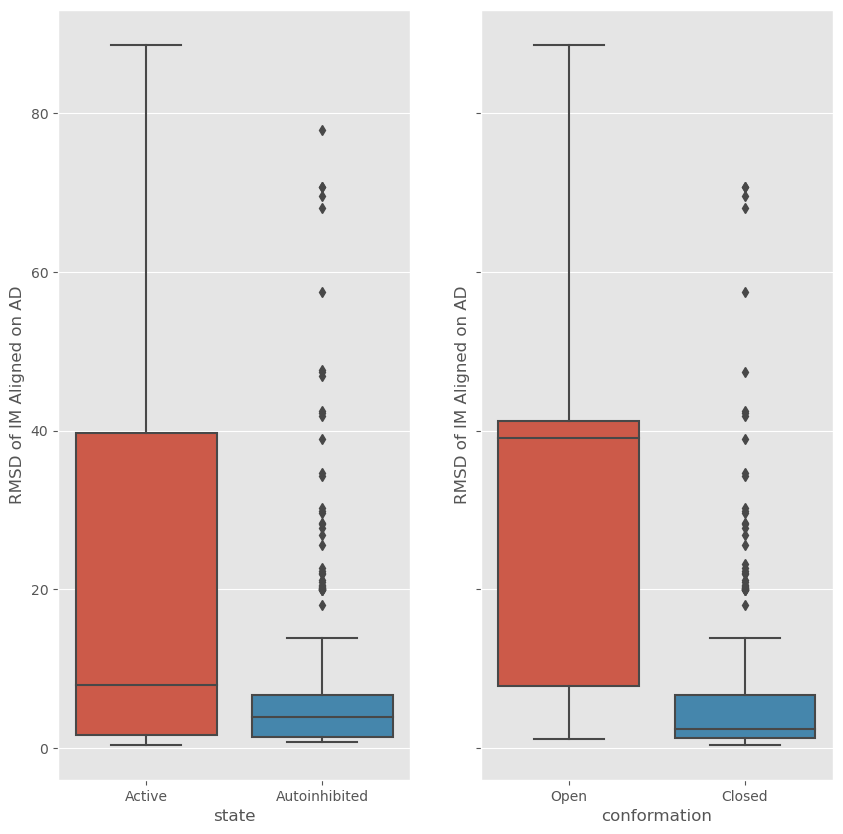

In [8]:
df_disorder = df_disorder.astype({'region_1_mean_plddt': 'float', '2_comp': 'float'})
# Remove outlier
df_disorder = df_disorder[df_disorder['2_comp'] < 100]

df_active = df_disorder[df_disorder['state'] == 'Active']
df_autoin = df_disorder[df_disorder['state'] == 'Autoinhibited']
df_open = df_disorder[df_disorder['conformation'] == 'Open']
df_closed = df_disorder[df_disorder['conformation'] == 'Closed']

g1 = sns.FacetGrid(data=df_disorder, col='state')
g1.map(sns.boxplot, 'conformation', '2_comp', order=['Open', 'Closed'])
g1.set_axis_labels('Conformation', 'RMSD of IM Aligned on AD')
g1.savefig('./project_pipeline/data/figures/rmsd_state.png', dpi=300, bbox_inches='tight')

g2 = sns.FacetGrid(data=df_disorder, col='conformation')
g2.map(sns.boxplot, 'state', '2_comp', order=['Active', 'Autoinhibited'])
g2.set_axis_labels('State', 'RMSD of IM Aligned on AD')
g2.savefig('./project_pipeline/data/figures/rmsd_conformation.png', dpi=300, bbox_inches='tight')

fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

sns.boxplot(ax=axes[0], data=df_disorder, x='state', y='2_comp')
axes[0].set_ylabel('RMSD of IM Aligned on AD')

sns.boxplot(ax=axes[1], data=df_disorder, x='conformation', y='2_comp')
axes[1].set_ylabel('RMSD of IM Aligned on AD')

plt.savefig('./project_pipeline/data/figures/rmsd.png', dpi=300, bbox_inches='tight')

# Determine how many structures in each category
act_op = df_disorder[(df_disorder['state'] == 'Active') & (df_disorder['conformation'] == 'Open')]
act_clo = df_disorder[(df_disorder['state'] == 'Active') & (df_disorder['conformation'] == 'Closed')]
aut_op = df_disorder[(df_disorder['state'] == 'Autoinhibited') & (df_disorder['conformation'] == 'Open')]
aut_clo = df_disorder[(df_disorder['state'] == 'Autoinhibited') & (df_disorder['conformation'] == 'Closed')]

print('Number  of Active and open: ' + str(len(act_op)))
print('Number of active and closed: ' + str(len(act_clo)))
print('Number of autoinhibited and open: ' + str(len(aut_op)))
print('Number of autoinhibited and closed: ' + str(len(aut_clo)))

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

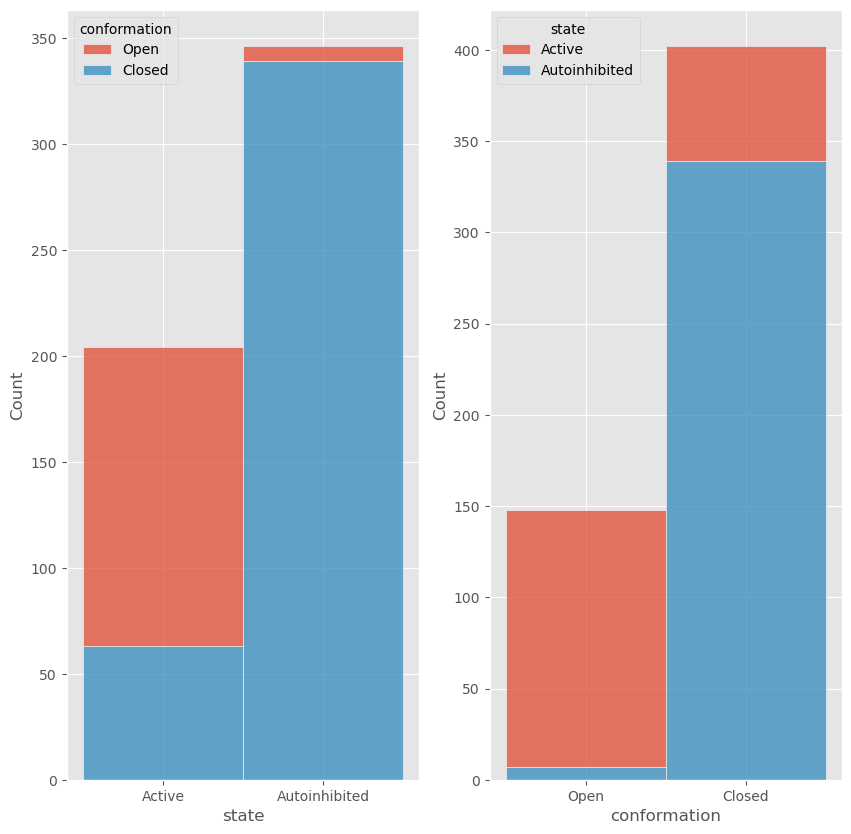

In [18]:
'''
Display counts of the subcategories
'''

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

sns.histplot(data=df_disorder, x='state', hue='conformation', ax=ax[0], multiple='stack')
sns.histplot(data=df_disorder, x='conformation', hue='state', ax=ax[1], multiple='stack')

plt.savefig('./project_pipeline/data/figures/count_of_subcategories.png')
plt.show()

258


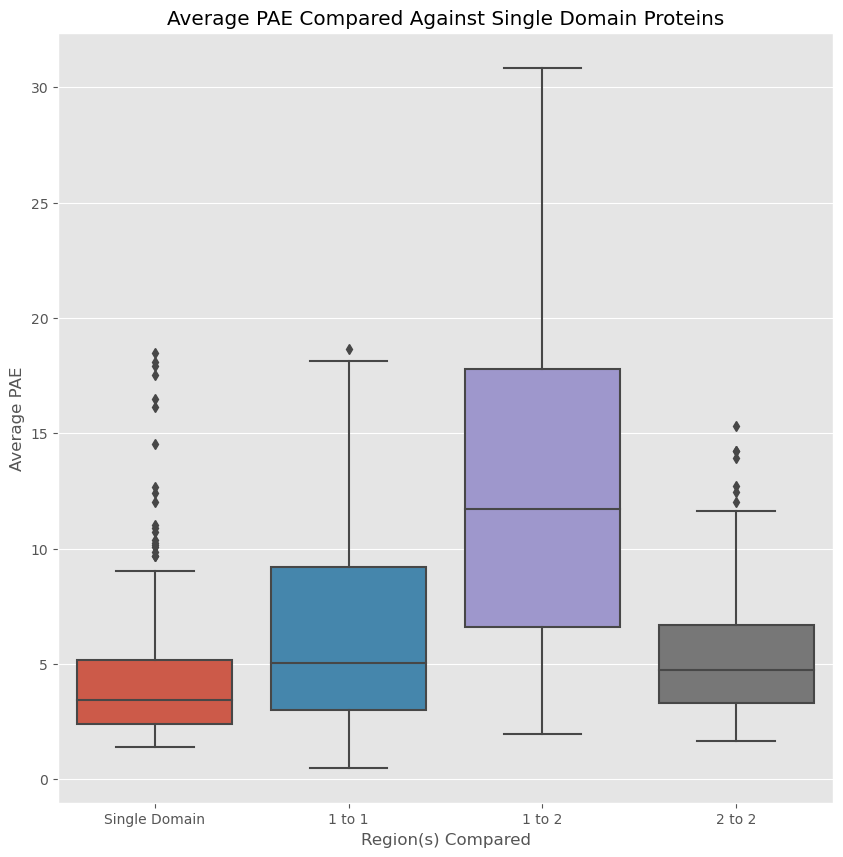

In [28]:
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')

# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)

# Reformat the dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
print(len(df_single))



df_all = df_single.merge(df_pae, how='outer')
df_all_melt = df_all.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')
df_all_melt.head()

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
sns.boxplot(data=df_all_melt, x='region', y='mean_pae', ax=ax)
ax.set_xlabel('Region(s) Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Compared Against Single Domain Proteins')

plt.savefig('./project_pipeline/data/figures/single_domain.png')
plt.show()

54


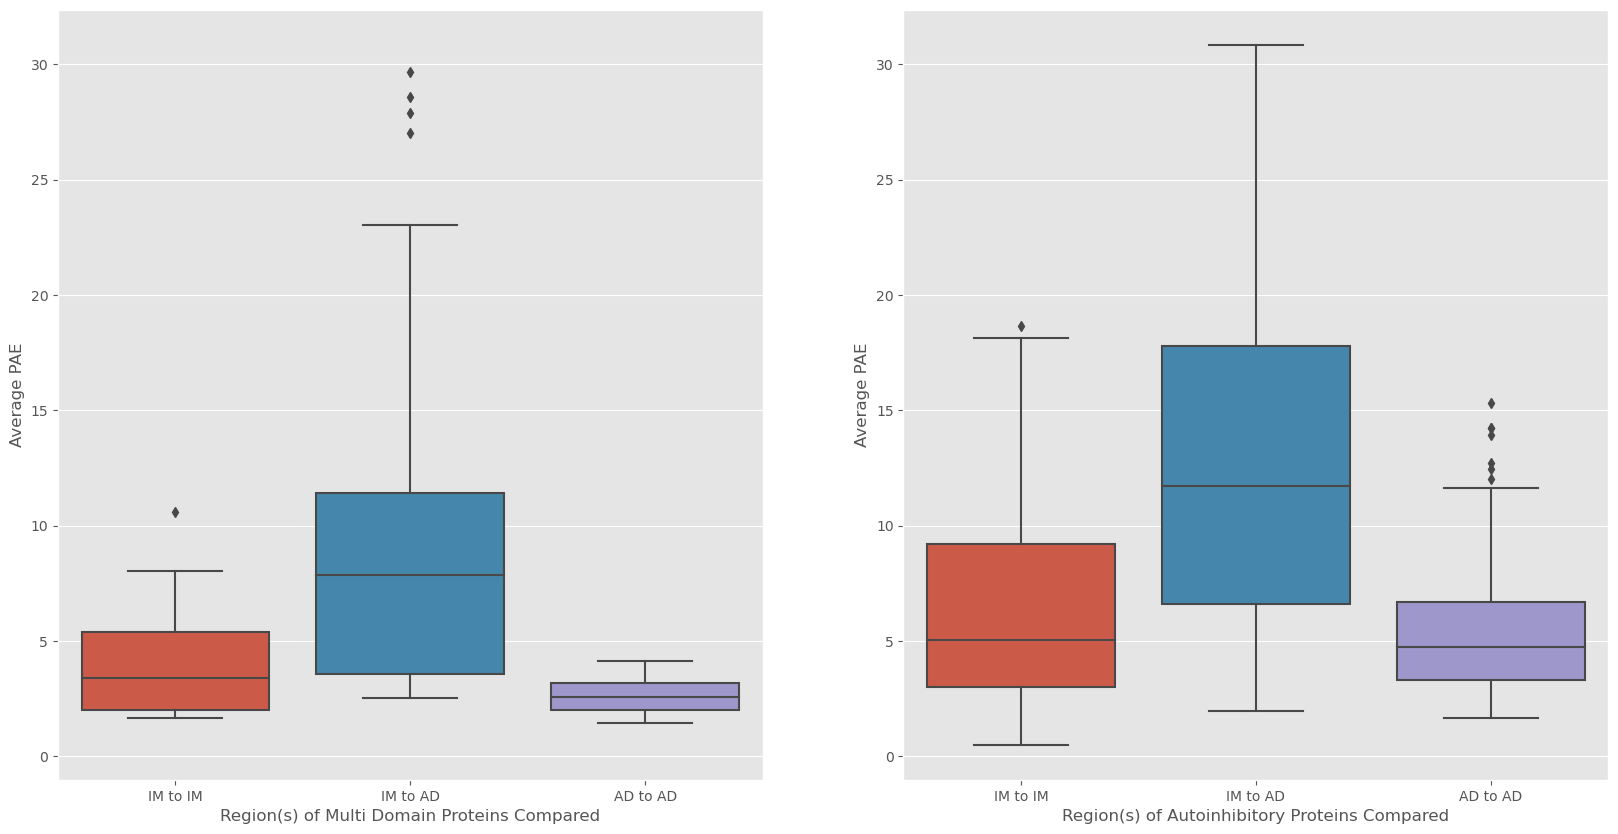

,uniprot,region,mean_pae
0,Q72AS4,IM to IM,1.767
1,Q7CRA4,IM to IM,6.426
2,P14677,IM to IM,1.65
3,P00582,IM to IM,8.028
4,A0A0H2WY27,IM to IM,1.845


In [42]:
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'IM to IM', 'mean_pae_1_2': 'IM to AD', 'mean_pae_2_2': 'AD to AD'})
print(len(df_multi))

# Reformat the dataframe
df_multi = df_multi.dropna()

df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').dropna().reset_index(drop=True)

# df_combined = df_multi.merge(df_pae, how='outer')

df_pae = df_pae.rename(columns={'1 to 1': 'IM to IM', '1 to 2': 'IM to AD', '2 to 2': 'AD to AD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').dropna().reset_index(drop=True)

fig=plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
sns.boxplot(data=df_multi_melt, x='region', y='mean_pae', ax=ax1)
ax1.set_xlabel('Region(s) of Multi Domain Proteins Compared')
ax1.set_ylabel('Average PAE')

sns.boxplot(data=df_pae_melt, x='region', y='mean_pae', ax=ax2)
ax2.set_xlabel('Region(s) of Autoinhibitory Proteins Compared')
ax2.set_ylabel('Average PAE')

# plt.savefig('./project_pipeline/data/figures/multi_domain.png')
plt.show()


df_multi_melt.head()

In [30]:
'''
Test significance of differences in predicted aligned error between our multi-domain set and our autoinhibitory set.
'''

g1 = df_pae_melt[df_pae_melt['region'] == '1 to 1']
g2 = df_pae_melt[df_pae_melt['region'] == '1 to 2']
g3 = df_pae_melt[df_pae_melt['region'] == '2 to 2']
g4 = df_pae_melt[df_pae_melt['region'] == 'multi_1_1']
g5 = df_pae_melt[df_pae_melt['region'] == 'multi_1_2']
g6 = df_pae_melt[df_pae_melt['region'] == 'multi_2_2']

g1xg4 = sp.stats.ttest_ind(g1['mean_pae'], g4['mean_pae'], equal_var=False)
g2xg5 = sp.stats.ttest_ind(g2['mean_pae'], g5['mean_pae'], equal_var=False)
g3xg6 = sp.stats.ttest_ind(g3['mean_pae'], g6['mean_pae'], equal_var=False)

print(f"Welch's t-test for region 1 vs region 1: {g1xg4}")
print(f"Welch's t-test for region 1 vs region 2: {g2xg5}")
print(f"Welch's t-test for region 2 vs region 2: {g3xg6}")

auto_11_12 = sp.stats.ttest_ind(g1['mean_pae'], g2['mean_pae'], equal_var=False)
auto_11_22 = sp.stats.ttest_ind(g1['mean_pae'], g3['mean_pae'], equal_var=False)
auto_12_22 = sp.stats.ttest_ind(g2['mean_pae'], g3['mean_pae'], equal_var=False)

multi_11_12 = sp.stats.ttest_ind(g4['mean_pae'], g5['mean_pae'], equal_var=False)
multi_11_22 = sp.stats.ttest_ind(g4['mean_pae'], g6['mean_pae'], equal_var=False)
multi_12_22 = sp.stats.ttest_ind(g5['mean_pae'], g6['mean_pae'], equal_var=False)

print(f"Welch's t-test for IM to IM vs IM to AD in autoinhibitory proteins: {auto_11_12}")
print(f"Welch's t-test for IM to IM vs AD to AD in autoinhibitory proteins: {auto_11_22}")
print(f"Welch's t-test for IM to AD vs AD to AD in autoinhibitory proteins: {auto_12_22}")

print(f"Welch's t-test for IM to IM vs IM to AD in multi-domain proteins: {multi_11_12}")
print(f"Welch's t-test for IM to IM vs AD to AD in multi-domain proteins: {multi_11_22}")
print(f"Welch's t-test for IM to AD vs AD to AD in multi-domain proteins: {multi_12_22}")


Welch's t-test for region 1 vs region 1: Ttest_indResult(statistic=5.394023633280461, pvalue=2.2119803618050367e-07)
Welch's t-test for region 1 vs region 2: Ttest_indResult(statistic=2.928887011265644, pvalue=0.0041803874907772095)
Welch's t-test for region 2 vs region 2: Ttest_indResult(statistic=9.877672205192809, pvalue=4.494046097121294e-18)
Welch's t-test for IM to IM vs IM to AD in autoinhibitory proteins: Ttest_indResult(statistic=-8.330892055050622, pvalue=1.3224531063814134e-14)
Welch's t-test for IM to IM vs AD to AD in autoinhibitory proteins: Ttest_indResult(statistic=1.893508527325175, pvalue=0.059636273602418424)
Welch's t-test for IM to AD vs AD to AD in autoinhibitory proteins: Ttest_indResult(statistic=10.237117319097738, pvalue=3.0968257212002105e-19)
Welch's t-test for IM to IM vs IM to AD in multi-domain proteins: Ttest_indResult(statistic=-5.479370827745589, pvalue=8.640654438435211e-07)
Welch's t-test for IM to IM vs AD to AD in multi-domain proteins: Ttest_indRe